## HOLO version of TOML config file workbook

In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import exampledata

import xarray
import matplotlib.pyplot as plt

## Load a TOML config file containing all setttings, and pipeline steps

This creates a dict of all settings, which can be modified or writte in the same way as any other dictionary in python. This has a slightly different structure that the old 'steps' dict, but follows the same principle (look in the example config.toml file used below for more details).

In [8]:
toml_settings = pyopia.io.load_toml('config-holo.toml')
toml_settings

{'general': {'raw_files': 'holo_test_data_01/*.pgm', 'pixel_size': 4.4},
 'steps': {'initial': {'pipeline_class': 'pyopia.instrument.holo.Initial',
   'filename': 'holo_test_data_01/001-2043.pgm',
   'pixel_size': 4.4,
   'wavelength': 658,
   'n': 1.33,
   'offset': 27,
   'minZ': 0,
   'maxZ': 50,
   'stepZ': 0.5},
  'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'createbackground': {'pipeline_class': 'pyopia.background.CreateBackground',
   'average_window': 10,
   'instrument_module': 'holo'},
  'load': {'pipeline_class': 'pyopia.instrument.holo.Load'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'bgshift_function': 'accurate'},
  'reconstruct': {'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
   'stack_clean': 0.02},
  'focus': {'pipeline_class': 'pyopia.instrument.holo.Focus'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.9},
  'statextra

## Run the pipeline

(same as before, but now giving Pipeline() the toml_setting dict)

In [9]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_settings)

# Load an image (from the test suite)
filename = 'holo_test_data_01/001-2043.pgm'

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: holo_test_data_01/*.pgm
Initial  ready with: {'filename': 'holo_test_data_01/001-2043.pgm', 'pixel_size': 4.4, 'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['settings', 'raw_files'])
Using given raw file to determine image dimensions
Build kernel
HoloInitial done 2023-08-29 22:41:39.259856
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack'])
CreateBackground  ready with: {'average_window': 10, 'instrument_module': 'holo'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl'])
Pipeline ready with these data:  ['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg']
Load  ready with: {}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready

## Load the data again

Then later, we can load the data again from NetCDF using xarray

xarray DataSets are presented nicely in notebooks (rendered poorly on GitHub's webinterface)

In [10]:
with xarray.open_dataset('proc/test-STATS.nc') as xstats:
    xstats.load()

xstats

<xarray.Dataset>
Dimensions:                     (index: 88)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 5 ... 82 83 84 85 86 87
    time                        (index) datetime64[ns] 2018-07-06T18:15:39.00...
Data variables: (12/17)
    export name                 (index) object 'D20180706T181539.002043-PN0' ...
    major_axis_length           (index) float64 13.48 7.717 ... 8.869 5.055
    minor_axis_length           (index) float64 10.7 5.712 5.206 ... 8.442 3.843
    equivalent_diameter         (index) float64 7.899 6.58 6.482 ... 8.593 4.222
    minr                        (index) float64 53.0 61.0 ... 1.159e+03
    minc                        (index) float64 721.0 551.0 ... 1.224e+03
    ...                          ...
    probability_faecal_pellets  (index) float64 9.333e-17 ... 2.654e-14
    probability_copepod         (index) float64 1.952e-36 ... 3.018e-21
    probability_diatom_chain    (index) float64 3.221e-36 1.019e-18 ... 1.84e-32
    probability_oily_gas        (index) float64 3.303e-30 9.78e-12 ... 9.055e-21
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:39.00...
    saturation                  (index) float64 0.7743 0.7743 ... 0.7743 0.7743
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2023-08-29 22:41:56.584756
    PyOpia version:  0.1.0

## Alter settings and re-process

What if we wanted to re-process this dataset with a different segmentation threshold?

### Get the TOML steps from the xarray DataSet

In [11]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'holo_test_data_01/*.pgm', 'pixel_size': 4.4},
 'steps': {'initial': {'pipeline_class': 'pyopia.instrument.holo.Initial',
   'filename': 'holo_test_data_01/001-2043.pgm',
   'pixel_size': 4.4,
   'wavelength': 658,
   'n': 1.33,
   'offset': 27,
   'minZ': 0,
   'maxZ': 50,
   'stepZ': 0.5},
  'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'createbackground': {'pipeline_class': 'pyopia.background.CreateBackground',
   'average_window': 10,
   'instrument_module': 'holo'},
  'load': {'pipeline_class': 'pyopia.instrument.holo.Load'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'bgshift_function': 'accurate'},
  'reconstruct': {'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
   'stack_clean': 0.02},
  'focus': {'pipeline_class': 'pyopia.instrument.holo.Focus'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.9},
  'statextra

### Alter the setting we want to change

In [24]:
toml_steps['steps']['focus']['threshold'] = 0.5

### re-process the pipeline

In [25]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_steps)

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: holo_test_data_01/*.pgm
Initial  ready with: {'filename': 'holo_test_data_01/001-2043.pgm', 'pixel_size': 4.4, 'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['settings', 'raw_files'])
Using given raw file to determine image dimensions
Build kernel
HoloInitial done 2023-08-29 23:00:53.154706
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack'])
CreateBackground  ready with: {'average_window': 10, 'instrument_module': 'holo'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl'])
Pipeline ready with these data:  ['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg']
Load  ready with: {}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready

### Further analysis

At this point we could write this to disc again (using the pyopia.io.write_stats function)

and/or we could build a new, correctly formatted, xarray for immediate use (which we will do here):

In [27]:
xstats_modified = pyopia.io.make_xstats(stats, toml_steps)
xstats_modified

<xarray.Dataset>
Dimensions:                     (index: 4)
Coordinates:
  * index                       (index) int64 0 1 2 3
    time                        (index) datetime64[ns] 2018-07-06T18:15:39.00...
Data variables: (12/17)
    major_axis_length           (index) float64 30.76 8.48 11.55 14.97
    minor_axis_length           (index) float64 15.63 4.422 9.443 10.33
    equivalent_diameter         (index) float64 20.93 6.18 10.34 12.21
    minr                        (index) float64 562.0 609.0 848.0 869.0
    minc                        (index) float64 840.0 844.0 441.0 849.0
    maxr                        (index) float64 590.0 616.0 858.0 882.0
    ...                          ...
    probability_copepod         (index) float64 6.072e-05 ... 7.326e-09
    probability_diatom_chain    (index) float64 1.976e-10 2.1e-11 ... 2.999e-10
    probability_oily_gas        (index) float64 3.704e-08 ... 4.055e-09
    export name                 (index) object 'D20180706T181539.002043-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:39.00...
    saturation                  (index) float64 0.09983 0.09983 0.09983 0.09983
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2023-08-29 23:07:59.247338
    PyOpia version:  0.1.0

### Plotting

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

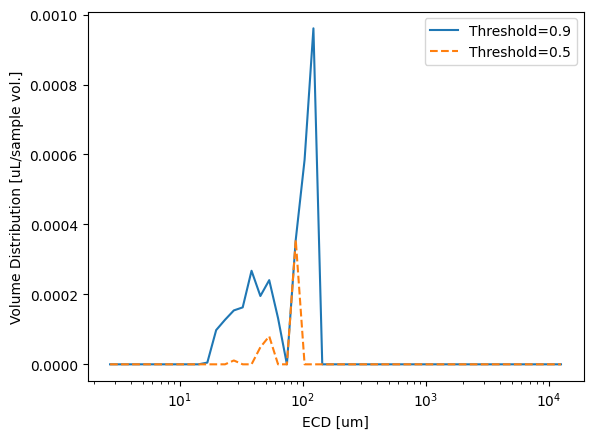

In [28]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

plt.plot(dias, vd, label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats)['steps']['segmentation']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

dias_modified, vd_modified = pyopia.statistics.vd_from_stats(xstats_modified, pyopia.pipeline.steps_from_xstats(xstats_modified)['general']['pixel_size'])

plt.plot(dias_modified, vd_modified, '--', label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']['segmentation']['threshold']}")

plt.legend()

# Remaining things to do/fix that are not covered in this notebook:

* create a pyopia.main that does administration (instead of this notebook) and has command-line inputs with config.toml file as input
* a pyopia.main should automatically setup the pipeline and process the images in settings['general']['raw_files'] file list in pipeline.run()